In [72]:
# ============================
# 📦 Essential Imports
# ============================

import os                               # OS-level operations (file paths, directories)
import random                           # For generating random triplets
import numpy as np                      # Numerical operations
import cv2                              # Image loading and processing
import tensorflow as tf                 # Core deep learning framework

# ============================
# 🧱 Model Utilities
# ============================

from tensorflow.keras.utils import Sequence              # For creating custom data generators
from tensorflow.keras.applications.resnet50 import preprocess_input  # Preprocessing for ResNet50
from tensorflow.keras.layers import Layer                # For creating custom attention layers
from sklearn.metrics.pairwise import cosine_similarity   # For embedding comparison (cosine distance)
from sklearn.metrics import accuracy_score, f1_score     # For evaluation metrics
from tensorflow.keras.callbacks import ModelCheckpoint   # To save best model during training
import matplotlib.pyplot as plt                          # For plotting training curves
from tensorflow.keras.layers import Lambda               # For functional Lambda layer (e.g., L2 normalize)
from tensorflow.keras import Input, Model                # For building custom Keras models


In [73]:
def load_person_image_dict(root_dir):
    """
    Loads image paths for each person from the given root directory.
    Supports both clean and distorted images (if present).

    Directory structure:
    root_dir/
        person_1/
            clean1.jpg
            clean2.jpg
            distortion/
                blurry1.jpg
                rainy1.jpg
        person_2/
            clean1.jpg
            distortion/
                noisy1.jpg
    """

    person_dict = {}  # Dictionary to store image paths per person

    # Loop through each person's folder
    for person_name in os.listdir(root_dir):
        person_path = os.path.join(root_dir, person_name)

        # Skip if it's not a directory
        if not os.path.isdir(person_path):
            continue

        image_list = []  # List to store all valid image paths for one person

        # === Step 1: Add Clean Images ===
        for f in os.listdir(person_path):
            if f.lower().endswith(('.jpg', '.png')) and "distortion" not in f:
                image_list.append(os.path.join(person_path, f))  # Clean image path

        # === Step 2: Add Distorted Images (if any) ===
        distort_path = os.path.join(person_path, "distortion")
        if os.path.exists(distort_path):  # Check if "distortion" subfolder exists
            for f in os.listdir(distort_path):
                if f.lower().endswith(('.jpg', '.png')):
                    image_list.append(os.path.join(distort_path, f))  # Distorted image path

        # Add to dictionary only if person has at least 1 anchor-positive pair
        if len(image_list) >= 2:
            person_dict[person_name] = image_list

    return person_dict  # Format: { "person_1": [img1, img2, ...], ... }


In [87]:
def preprocess_image(path):
    """
    Loads and preprocesses a face image for ResNet50.

    Args:
        path (str): File path to the image.

    Returns:
        Preprocessed image as a NumPy array (float32), ready for model inference.
    """
    
    # Read the image using OpenCV (returns image in BGR format)
    img = cv2.imread(path)
    
    # If the image is not found or unreadable, raise an error
    if img is None:
        raise ValueError(f"Image not found or unreadable: {path}")
    
    # Resize the image to 224x224 pixels (ResNet50 input size)
    img = cv2.resize(img, (224, 224))
    
    # Convert BGR (OpenCV default) to RGB format (expected by most DL models)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Apply ResNet50 preprocessing (converts RGB to BGR, zero-centers with ImageNet means)
    img = tf.keras.applications.resnet50.preprocess_input(img.astype('float32'))
    
    # Return the preprocessed image
    return img


In [101]:
class TripletGenerator(Sequence):
    """
    Custom data generator for training a triplet loss model.

    It yields batches of triplets: (anchor, positive, negative),
    where:
    - anchor and positive come from the same identity (clean/distorted),
    - negative is from a different identity.
    """

    def __init__(self, person_dict, batch_size=32, image_size=(224, 224)):
        """
        Args:
            person_dict (dict): Dictionary mapping person names to list of image paths.
            batch_size (int): Number of triplets per batch.
            image_size (tuple): Target image size for resizing.
        """
        self.person_dict = person_dict
        self.persons = list(person_dict.keys())  # All identity names
        self.batch_size = batch_size
        self.image_size = image_size
        self.triplets = self._create_triplets()  # Precompute all valid triplets

    def _create_triplets(self):
        """
        Generates a list of valid (anchor, positive, negative) image path triplets.
        """
        triplets = []
        for person in self.persons:
            images = self.person_dict[person]
            for i in range(len(images)):
                for j in range(len(images)):
                    if i == j:
                        continue  # Avoid using the same image as both anchor and positive
                    anchor = images[i]
                    positive = images[j]
                    # Select a random different person for the negative
                    negative_person = random.choice([p for p in self.persons if p != person])
                    negative_image = random.choice(self.person_dict[negative_person])
                    triplets.append((anchor, positive, negative_image))
        
        random.shuffle(triplets)  # Shuffle for better training variety
        return triplets

    def __len__(self):
        """
        Number of batches per epoch.
        """
        return len(self.triplets) // self.batch_size

    def __getitem__(self, idx):
        """
        Generates a single batch of triplets.
        Returns:
            Tuple of 3 image tensors (anchor, positive, negative) and dummy labels.
        """
        # Select batch triplets
        triplets = self.triplets[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Allocate empty NumPy array for all images
        batch_images = np.zeros((len(triplets), 3, 224, 224, 3), dtype=np.float32)

        # Load and preprocess anchor, positive, and negative images
        for i, (a, p, n) in enumerate(triplets):
            batch_images[i, 0] = preprocess_image(a)  # Anchor
            batch_images[i, 1] = preprocess_image(p)  # Positive
            batch_images[i, 2] = preprocess_image(n)  # Negative

        # Split into 3 separate tensors for model input
        anchor = batch_images[:, 0, :, :, :]
        positive = batch_images[:, 1, :, :, :]
        negative = batch_images[:, 2, :, :, :]

        # Dummy labels are required by Keras even though triplet loss is self-supervised
        dummy_labels = np.zeros((len(triplets),))

        return (anchor, positive, negative), dummy_labels

    def _load_image(self, path):
        """
        Alternative image loading function (currently unused).
        Resizes, converts to RGB, and applies ResNet preprocessing.
        """
        img = cv2.imread(path)
        img = cv2.resize(img, self.image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return preprocess_input(img.astype('float32'))


In [102]:
# ===============================
# 🧠 Load Person-Image Dictionary
# ===============================

# This function reads the "train" folder and returns a dictionary
# Format: { "person_1": [img1_path, img2_path, ...], "person_2": [...], ... }
train_dict = load_person_image_dict("train")  # Training data
val_dict   = load_person_image_dict("val")    # Validation data

# ===============================
# ⚙️ Create Triplet Data Generators
# ===============================

# These generators yield batches of triplets: (anchor, positive, negative)
# Each batch has 3 arrays of shape (batch_size, 224, 224, 3)
# and a dummy label array for compatibility with Keras training loop

train_gen = TripletGenerator(train_dict, batch_size=32)
val_gen   = TripletGenerator(val_dict, batch_size=32)


In [103]:
def se_block(input_tensor, ratio=8):
    """
    Squeeze-and-Excitation (SE) block for channel-wise attention.

    Args:
        input_tensor (tf.Tensor): Input feature map (e.g., from a convolutional layer).
        ratio (int): Reduction ratio for bottleneck in SE block. Controls the size of the hidden layer.

    Returns:
        tf.Tensor: Output tensor with channel-wise attention applied.
    """

    # Get the number of channels in the input feature map
    filters = input_tensor.shape[-1]

    # Define the shape to reshape pooled features (1, 1, num_channels)
    se_shape = (1, 1, filters)

    # === Squeeze: Global spatial information is aggregated into a channel descriptor ===
    se = layers.GlobalAveragePooling2D()(input_tensor)   # Shape: (batch_size, channels)

    # === Reshape to match Conv2D format ===
    se = layers.Reshape(se_shape)(se)                    # Shape: (batch_size, 1, 1, channels)

    # === Excitation: Two fully connected (Dense) layers to learn non-linear channel weights ===
    se = layers.Dense(filters // ratio, activation='relu', use_bias=False)(se)  # Bottleneck
    se = layers.Dense(filters, activation='sigmoid', use_bias=False)(se)        # Output weights

    # === Scale: Multiply learned weights with input feature maps (channel-wise multiplication) ===
    return layers.Multiply()([input_tensor, se])  # Final output with attention applied


In [104]:
import tensorflow as tf
from tensorflow.keras import layers

class CBAM(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=8):
        """
        Initialize the CBAM layer.

        Args:
            reduction_ratio (int): Bottleneck ratio for the channel attention MLP.
        """
        super(CBAM, self).__init__()
        self.reduction_ratio = reduction_ratio  # Controls compression in MLP

    def build(self, input_shape):
        """
        Build the weights and layers required for CBAM.

        Args:
            input_shape: Shape of the input tensor (batch, H, W, C)
        """
        self.channel = input_shape[-1]  # Number of channels in input

        # === Shared MLP layers for channel attention ===
        self.shared_dense_one = layers.Dense(self.channel // self.reduction_ratio, activation='relu')
        self.shared_dense_two = layers.Dense(self.channel)

        # === Convolution for spatial attention ===
        self.conv_spatial = layers.Conv2D(
            filters=1,                # Single spatial attention map
            kernel_size=(7, 7),       # Large receptive field
            padding='same',
            activation='sigmoid'      # Attention values in [0,1]
        )

    def call(self, input_tensor):
        """
        Forward pass of the CBAM module.

        Args:
            input_tensor: Input feature map (batch, H, W, C)

        Returns:
            Refined feature map with both channel and spatial attention.
        """

        # ================
        # CHANNEL ATTENTION
        # ================

        # Global average and max pooling across spatial dimensions
        avg_pool = layers.GlobalAveragePooling2D()(input_tensor)  # (batch, C)
        max_pool = layers.GlobalMaxPooling2D()(input_tensor)      # (batch, C)

        # Shared MLP applied to both pooled features
        avg_fc = self.shared_dense_two(self.shared_dense_one(avg_pool))  # (batch, C)
        max_fc = self.shared_dense_two(self.shared_dense_one(max_pool))  # (batch, C)

        # Merge and activate (sigmoid) to get attention weights
        channel_attention = layers.Add()([avg_fc, max_fc])  # (batch, C)
        channel_attention = tf.nn.sigmoid(channel_attention)  # (batch, C)

        # Reshape to (batch, 1, 1, C) for broadcasting
        channel_attention = tf.reshape(channel_attention, [-1, 1, 1, self.channel])

        # Apply channel attention (multiply input with attention map)
        channel_refined = input_tensor * channel_attention  # (batch, H, W, C)

        # =================
        # SPATIAL ATTENTION
        # =================

        # Reduce channel dimension by average and max across channels
        avg_pool_spatial = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
        max_pool_spatial = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)

        # Concatenate across the channel axis: shape = (batch, H, W, 2)
        concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])

        # Apply convolution to get spatial attention map
        spatial_attention = self.conv_spatial(concat)  # (batch, H, W, 1)

        # Apply spatial attention
        refined = layers.Multiply()([channel_refined, spatial_attention])  # Final refined features

        return refined


In [105]:
import tensorflow as tf
from tensorflow.keras import layers, models
from custom_layers import CBAM, se_block  # Make sure these are defined or imported properly

# === Load pretrained ResNet50 as base feature extractor ===
base_model = tf.keras.applications.ResNet50(
    include_top=False,         # Remove classification head
    weights='imagenet',        # Load ImageNet-pretrained weights
    input_shape=(224, 224, 3)  # Input size for face images
)
base_model.trainable = False  # Freeze base layers to retain pretrained features

# === Extract output of the last convolutional block from ResNet50 ===
x = base_model.output

# === Custom convolution layer to enhance ResNet features ===
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# === Squeeze-and-Excitation block for channel attention ===
x = se_block(x)  # Learns channel-wise feature importance

# === CBAM block for both channel + spatial attention ===
x = CBAM()(x)  # Learns spatial + channel-wise focus

# === Additional Conv layer to refine features ===
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# === Global Average Pooling to flatten spatial dimensions ===
x = layers.GlobalAveragePooling2D()(x)

# === Dense layer to compress features into 128-dim vector ===
x = layers.Dense(128, activation='relu')(x)

# === Dropout to prevent overfitting during training ===
x = layers.Dropout(0.4)(x)

# === L2-normalization to place embedding on unit hypersphere ===
embedding = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)

# === Final model: Input image ➜ Output normalized 128-d embedding ===
embedding_model = tf.keras.Model(inputs=base_model.input, outputs=embedding)

# === Print model summary for verification ===
embedding_model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_9[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,792,331 (94.58 MB)

 Trainable params: 1,204,619 (4.60 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [106]:
def triplet_loss(margin=0.2):
    """
    Returns a triplet loss function with a given margin.
    
    Args:
        margin (float): The minimum difference required between 
                        positive and negative distances (default is 0.2).
    
    Returns:
        _loss: A loss function that can be used with Keras models.
    """
    def _loss(y_true, y_pred):
        """
        Computes triplet loss.
        
        Args:
            y_true: Ground truth labels (ignored; required by Keras API).
            y_pred: Predicted embeddings of shape (batch_size, 3, embedding_dim),
                    where each triplet is [anchor, positive, negative].
        
        Returns:
            Scalar loss value for the batch.
        """

        # Split embeddings: shape → (batch_size, embedding_dim)
        anchor = y_pred[:, 0, :]   # Anchor embedding
        positive = y_pred[:, 1, :] # Positive (same identity as anchor)
        negative = y_pred[:, 2, :] # Negative (different identity)

        # Compute squared L2 distance between anchor and positive
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)

        # Compute squared L2 distance between anchor and negative
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)

        # Compute triplet loss:
        # Ensures anchor-positive is closer than anchor-negative by at least `margin`
        loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)

        # Return average loss over the batch
        return tf.reduce_mean(loss)

    return _loss


In [107]:
def build_training_model(embedding_model):
    """
    Constructs a training model for triplet loss using a shared embedding model.

    Args:
        embedding_model (tf.keras.Model): The base model that outputs a 128-d normalized embedding
                                          for a single image input.

    Returns:
        model (tf.keras.Model): A Keras model that takes (anchor, positive, negative) images as input
                                and outputs their corresponding stacked embeddings.
    """

    # === Define 3 input layers for anchor, positive, and negative images ===
    anchor_input = Input(shape=(224, 224, 3), name='anchor_input')      # Clean image
    positive_input = Input(shape=(224, 224, 3), name='positive_input')  # Distorted or alternate image of same person
    negative_input = Input(shape=(224, 224, 3), name='negative_input')  # Image of a different person

    # === Pass each input through the shared embedding model ===
    anchor_embed   = embedding_model(anchor_input)    # Shape: (None, 128)
    positive_embed = embedding_model(positive_input)  # Shape: (None, 128)
    negative_embed = embedding_model(negative_input)  # Shape: (None, 128)

    # === Stack the three embeddings into one tensor along axis=1 ===
    # Resulting shape: (None, 3, 128)
    # This format is required for computing triplet loss
    merged_output = layers.Lambda(lambda x: tf.stack(x, axis=1))(
        [anchor_embed, positive_embed, negative_embed]
    )

    # === Define the final training model ===
    # Inputs: (anchor, positive, negative)
    # Output: single stacked tensor used for loss calculation
    model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_output)

    return model


In [108]:
def preprocess_img(img_path):
    """
    Loads and preprocesses an image for ResNet50 inference.

    Args:
        img_path (str): Path to the image file.

    Returns:
        np.ndarray: Preprocessed image ready to be passed to ResNet50 model. Shape: (1, 224, 224, 3)
    """

    # === Step 1: Read the image using OpenCV ===
    img = cv2.imread(img_path)  # Loads in BGR format

    # === Step 2: Resize the image to match ResNet50 input requirements ===
    img = cv2.resize(img, (224, 224))  # Resize to (224, 224)

    # === Step 3: Convert image from BGR to RGB ===
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # === Step 4: Apply ResNet50-specific preprocessing ===
    # Converts RGB to zero-centered with respect to the ImageNet dataset
    img = tf.keras.applications.resnet50.preprocess_input(img.astype('float32'))

    # === Step 5: Add a batch dimension ===
    return np.expand_dims(img, axis=0)  # Final shape: (1, 224, 224, 3)


In [109]:
def build_face_db(dataset_root, embedding_model):
    """
    Builds a face embedding database from clean (undistorted) images in the dataset.

    Args:
        dataset_root (str): Root directory containing folders for each person.
                            Each folder should contain clean and possibly distorted images.
        embedding_model (tf.keras.Model): Trained embedding model that outputs 128-d embeddings.

    Returns:
        dict: A dictionary mapping person names to their face embedding vectors.
              Format: { 'person_name': embedding_vector (np.ndarray of shape (128,)) }
    """

    face_db = {}  # Dictionary to store embeddings for each person

    # === Loop over each person's directory ===
    for person in os.listdir(dataset_root):
        person_path = os.path.join(dataset_root, person)

        # Skip non-directory files
        if not os.path.isdir(person_path):
            continue

        # === Select only clean (non-distorted) JPEG images ===
        clean_imgs = [f for f in os.listdir(person_path) 
                      if 'distortion' not in f and f.endswith('.jpg')]

        # Skip if no clean image found
        if not clean_imgs:
            continue

        # === Use the first clean image as the reference ===
        img_path = os.path.join(person_path, clean_imgs[0])
        img_tensor = preprocess_img(img_path)  # Preprocess image for model input

        # === Generate the 128-d embedding using the model ===
        embedding = embedding_model.predict(img_tensor)

        # === Store the embedding in the dictionary ===
        face_db[person] = embedding[0]  # Extract vector from batch (shape: (128,))

    return face_db


In [110]:
def predict_identity(test_img_path, face_db, embedding_model):
    """
    Predicts the identity of a given test image by comparing its embedding
    with those in the face database using cosine similarity.

    Args:
        test_img_path (str): Path to the test image.
        face_db (dict): A dictionary mapping person names to their 128-d face embeddings.
                        Format: { 'person_name': embedding_vector }
        embedding_model (tf.keras.Model): Trained model that outputs 128-d embeddings.

    Returns:
        (str, float): Tuple containing the predicted identity (person name) and similarity score.
    """

    # === Step 1: Preprocess the test image and get its embedding ===
    test_embedding = embedding_model.predict(preprocess_img(test_img_path))  # Shape: (1, 128)
    test_embedding = test_embedding[0].reshape(1, -1)  # Reshape to (1, 128) for similarity computation

    # === Step 2: Extract all identities and their embeddings from the database ===
    identities = list(face_db.keys())  # List of all person names
    embeddings = np.array([face_db[p] for p in identities])  # Shape: (num_persons, 128)

    # === Step 3: Compute cosine similarity between test image and each person in the DB ===
    sims = cosine_similarity(test_embedding, embeddings)[0]  # Output: (num_persons,)

    # === Step 4: Find the most similar identity ===
    best_idx = np.argmax(sims)  # Index of the highest similarity score

    # === Step 5: Return the predicted identity and its similarity score ===
    return identities[best_idx], sims[best_idx]


In [1]:
def evaluate_model(test_root, face_db, embedding_model):
    """
    Evaluates the face recognition model on a test dataset using Top-1 Accuracy and Macro F1 Score.

    Args:
        test_root (str): Root directory of the test dataset. Each folder is a person containing their images.
                         Each person's folder may have a 'distortion' subfolder for distorted test images.
        face_db (dict): Dictionary mapping person names to their 128-d embedding vectors.
        embedding_model (tf.keras.Model): The trained face embedding model.

    Returns:
        acc (float): Top-1 accuracy score.
        f1 (float): Macro-average F1 score.
    """

    y_true = []  # List of true person labels
    y_pred = []  # List of predicted labels

    # === Step 1: Loop through each person directory in the test set ===
    for person in os.listdir(test_root):
        person_path = os.path.join(test_root, person)

        # Skip if it's not a directory (e.g., stray files)
        if not os.path.isdir(person_path):
            continue

        # === Step 2: Get all images (clean + distorted) in that folder ===
        test_imgs = [f for f in os.listdir(person_path) if f.endswith('.jpg')]

        for img in test_imgs:
            # === Step 3: Construct full path to image ===
            if 'distortion' in img:
                # Image is inside 'distortion' subfolder
                img_path = os.path.join(person_path, 'distortion', img)
            else:
                # Clean image directly inside person's folder
                img_path = os.path.join(person_path, img)

            # === Step 4: Predict identity using the embedding model and face database ===
            pred_label, _ = predict_identity(img_path, face_db, embedding_model)

            # === Step 5: Save true and predicted labels for evaluation ===
            y_true.append(person)
            y_pred.append(pred_label)

    # === Step 6: Compute Top-1 Accuracy and Macro F1 score ===
    acc = accuracy_score(y_true, y_pred)                    # Overall correct predictions
    f1 = f1_score(y_true, y_pred, average='macro')          # Equal weight to each class (useful for imbalance)

    return acc, f1


In [112]:
# === Build the training model using the shared embedding model ===
# This model takes (anchor, positive, negative) inputs and outputs stacked embeddings for triplet loss
triplet_model = build_training_model(embedding_model)

# === Compile the model with Adam optimizer and custom triplet loss ===
triplet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Use Adam optimizer with learning rate of 0.0001
    loss=triplet_loss(margin=0.2)  # Apply custom triplet loss with a margin of 0.2
)


In [117]:
# === Define a checkpoint to save the best model during training ===
checkpoint = ModelCheckpoint(
    "best_triplet_model.h5",     # File path where the best model will be saved
    monitor="val_loss",          # Metric to monitor for improvement (validation loss)
    save_best_only=True,         # Only save the model if the monitored metric improves
    save_weights_only=False,     # Save the full model (architecture + weights)
    verbose=1                    # Print a message when the model is saved
)

# === Train the triplet model ===
history = triplet_model.fit(
    train_gen,                   # Training data generator (TripletGenerator instance)
    validation_data=val_gen,     # Validation data generator
    epochs=10,                   # Number of training epochs
    steps_per_epoch=40,          # Batches per epoch (you can adjust based on dataset size)
    validation_steps=20,         # Batches to validate on per epoch
    callbacks=[checkpoint],      # Callback to save the best model
    verbose=1                    # Print training progress to console
)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - loss: 0.0763 
Epoch 1: val_loss improved from inf to 0.18853, saving model to best_triplet_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 1061s 27s/step - loss: 0.0763 - val_loss: 0.1885
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.0656 
Epoch 2: val_loss improved from 0.18853 to 0.15079, saving model to best_triplet_model.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 1024s 26s/step - loss: 0.0656 - val_loss: 0.1508
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.0610 
Epoch 3: val_loss did not improve from 0.15079
40/40 ━━━━━━━━━━━━━━━━━━━━ 1021s 26s/step - loss: 0.0611 - val_loss: 0.2265
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.0676 
Epoch 4: val_loss did not improve from 0.15079
40/40 ━━━━━━━━━━━━━━━━━━━━ 1005s 25s/step - loss: 0.0674 - val_loss: 0.1595
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.0522 
Epoch 5: val_loss did not improve from 0.15079
40/40 ━━━━━━━━━━━━━━━━━━━━ 1006s 25s/step - loss: 0.0523 - val_loss: 0.1827
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.0537 
Epoch 6: val_loss did not improve from 0.15079
40/40 ━━━━━━━━━━━━━━━━━━━━ 1017s 26s/step - loss: 0.0537 - val_loss: 0.1744
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.0519 
Epoch 7: val_loss did not improve from 0.15079
40/40 ━━━━━━━━━━━━━━━━━━━━ 1018s 26s/step - loss: 0.052

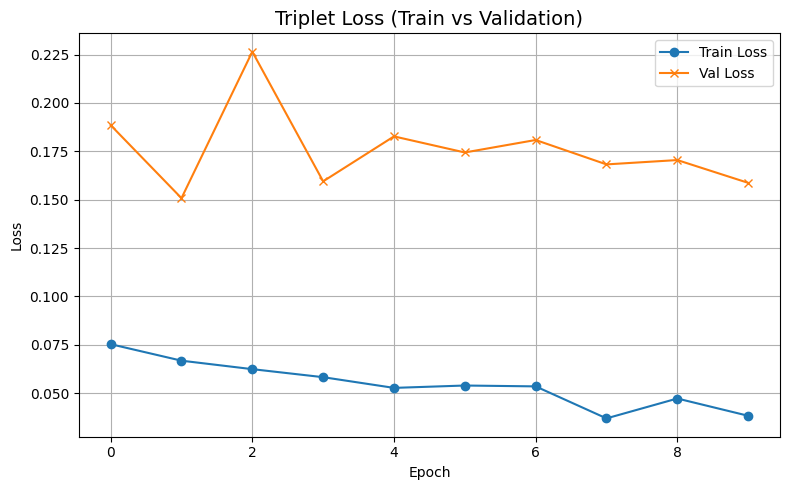

In [118]:
# === Create a new figure with specified size ===
plt.figure(figsize=(8, 5))  # Width: 8 inches, Height: 5 inches

# === Plot training loss per epoch ===
plt.plot(history.history['loss'], label='Train Loss', marker='o')  # Circle marker for clarity

# === Plot validation loss per epoch ===
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')  # X marker for validation points

# === Add plot title and axis labels ===
plt.title("Triplet Loss (Train vs Validation)", fontsize=14)  # Title of the plot
plt.xlabel("Epoch")  # X-axis label
plt.ylabel("Loss")   # Y-axis label

# === Show legend to distinguish lines ===
plt.legend()

# === Add grid for better readability ===
plt.grid(True)

# === Automatically adjust subplot params for better layout ===
plt.tight_layout()

# === Display the plot ===
plt.show()


In [119]:
# === Step 1: Define the dataset path for building the face database ===
dataset_path = "val"  # This directory contains subfolders of identities with clean/distorted images

# === Step 2: Build the face database from clean images using the trained embedding model ===
face_db = build_face_db(dataset_path, embedding_model)
# This returns a dictionary: { 'person_name': 128-d embedding }

# === Step 3: Set the path for the test dataset (can be the same as face_db source) ===
test_path = "val"  # You may use a separate test folder if available

# === Step 4: Evaluate the model's performance on the test dataset ===
accuracy, macro_f1 = evaluate_model(test_path, face_db, embedding_model)

# === Step 5: Print the Top-1 Accuracy and Macro F1 Score ===
print(f"Top-1 Accuracy: {accuracy*100:.2f}%")   # Format: e.g., 91.75%
print(f"Macro F1 Score: {macro_f1:.4f}")        # Format: e.g., 0.8921


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [120]:
# === Save the trained embedding model to disk ===
embedding_model.save("face_embedding_model.h5")
# This saves:
# - Model architecture
# - Trained weights
# - Optimizer configuration (if compiled)
# - Custom layers used (must be reloaded using `custom_objects`)
